In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, compute_statistics, NormalizeCube, NormalizeProfile

from pnet import pNet

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../dibasRP/all')
# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = [0.5] * 31, [0.5] * 31, [0.5] * 31, [0.5] * 31
# Define the custom transformations using the computed statistics
cube_transform = NormalizeCube(mean=channel_means_cube, std=channel_stds_cube)
profile_transform = NormalizeProfile(mean=channel_means_profile, std=channel_stds_profile)

# Apply the custom transforms to the datasets
train_dataset = HyperspectralDataset(root_dir='../../dibasRP/train', cube_transform=cube_transform, profile_transform=profile_transform)
val_dataset = HyperspectralDataset(root_dir='../../dibasRP/val', cube_transform=cube_transform, profile_transform=profile_transform)
test_dataset = HyperspectralDataset(root_dir='../../dibasRP/test', cube_transform=cube_transform, profile_transform=profile_transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 25, 'Streptococcus_agalactiae': 26, 'Staphylococcus_saprophiticus': 27, 'Bacteroides_fragilis': 28, 'Neisseria_gonorrhoeae': 29, 'Veionella': 30, 'Proteus': 31, 'Candida_albicans': 32}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [3]:
# Get file paths for the main dataset and each split
main_dataset_paths = get_all_file_paths(dataset)
train_dataset_paths = get_all_file_paths(train_dataset)
val_dataset_paths = get_all_file_paths(val_dataset)
test_dataset_paths = get_all_file_paths(test_dataset)

# Check if the total length of the splits equals the length of the main dataset
total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
if total_split_length != len(main_dataset_paths):
    print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
else:
    print("Total length of splits matches the length of the main dataset.")

# Check for overlaps between splits
def check_for_overlaps(paths1, paths2):
    overlaps = set(paths1) & set(paths2)
    return overlaps

train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

if train_val_overlaps:
    print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
else:
    print("No overlaps found between train and validation datasets.")

if train_test_overlaps:
    print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
else:
    print("No overlaps found between train and test datasets.")

if val_test_overlaps:
    print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
else:
    print("No overlaps found between validation and test datasets.")

Total length of splits matches the length of the main dataset.
No overlaps found between train and validation datasets.
No overlaps found between train and test datasets.
No overlaps found between validation and test datasets.


In [4]:
model = pNet().to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

In [6]:
import time

# Initialize lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_change_epochs = []

# Training loop
num_epochs = 150
total_start_time = time.time()  # Start timer for the whole training process

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timer for this epoch

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for _, profiles, labels in train_loader:
        profiles, labels = profiles.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(profiles)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for _, profiles, labels in val_loader:
            profiles, labels = profiles.to(device), labels.to(device)  # Move data to GPU
            outputs = model(profiles)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss and track LR changes
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        lr_change_epochs.append(epoch)
        print(f"Learning rate reduced from {old_lr} to {new_lr}")

    epoch_end_time = time.time()  # End timer for this epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

total_end_time = time.time()  # End timer for the whole training process
total_duration = total_end_time - total_start_time
print(f"Training completed in {total_duration:.2f} seconds")


Epoch [1/150], Loss: 3.4436, Training Accuracy: 10.45%
Validation Loss: 3.3929, Validation Accuracy: 15.79%
Epoch [1/150] completed in 1.75 seconds
Epoch [2/150], Loss: 3.3870, Training Accuracy: 15.86%
Validation Loss: 3.3676, Validation Accuracy: 18.42%
Epoch [2/150] completed in 1.59 seconds
Epoch [3/150], Loss: 3.3704, Training Accuracy: 17.91%
Validation Loss: 3.3498, Validation Accuracy: 19.74%
Epoch [3/150] completed in 1.55 seconds
Epoch [4/150], Loss: 3.3509, Training Accuracy: 19.59%
Validation Loss: 3.3547, Validation Accuracy: 21.05%
Epoch [4/150] completed in 1.62 seconds
Epoch [5/150], Loss: 3.3187, Training Accuracy: 23.32%
Validation Loss: 3.3467, Validation Accuracy: 18.42%
Epoch [5/150] completed in 1.60 seconds
Epoch [6/150], Loss: 3.3170, Training Accuracy: 22.95%
Validation Loss: 3.3168, Validation Accuracy: 22.37%
Epoch [6/150] completed in 1.58 seconds
Epoch [7/150], Loss: 3.3212, Training Accuracy: 22.39%
Validation Loss: 3.3416, Validation Accuracy: 21.05%
Epoc

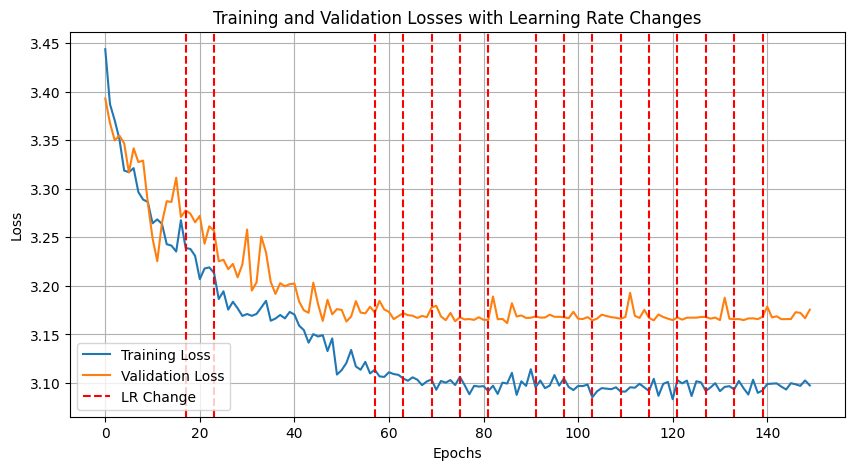

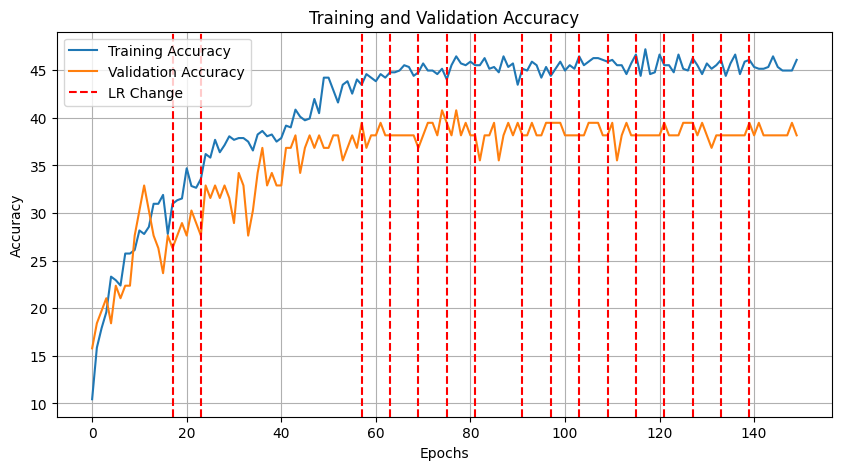

In [7]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.grid(True)  # Add gridlines
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)  # Add gridlines
plt.show()


<Figure size 1000x1000 with 0 Axes>

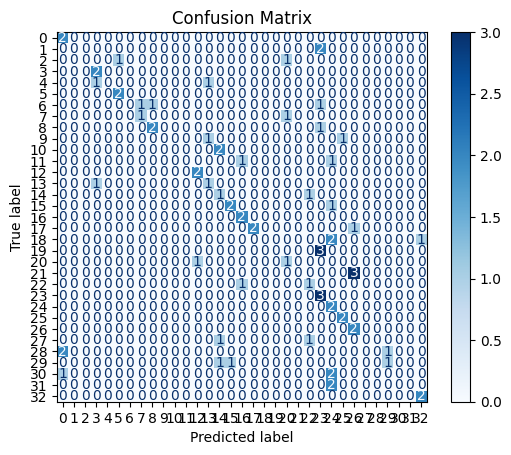

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to test an individual sample and collect predictions and true labels
def test_individual_test_sample(sample_idx, true_labels, predicted_labels):
    # Load a specific sample from the test dataset
    _, profile, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    profile = profile.to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(profile)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Append the true and predicted labels to their respective lists
    true_labels.append(label.item())
    predicted_labels.append(predicted_class.item())

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Test individual samples and collect labels
for i in range(len(test_dataset)):
    test_individual_test_sample(i, true_labels, predicted_labels)

# Convert lists to numpy arrays for compatibility with sklearn
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [9]:
torch.save(model.state_dict(), 'pnet.pth')

In [10]:
for name, param in model.named_parameters():
    print(name)

conv1.weight
conv1.bias
batch_norm1.weight
batch_norm1.bias
dense1.weight
dense1.bias
dense2.weight
dense2.bias
